# Predict taxa from media components

In [1]:
# Add higher directory to python modules path

import sys

sys.path.append("..")

In [2]:
import os

import pandas as pd

from matplotlib import pyplot as plt

import plotly.express as px

from sklearn.cluster import KMeans

import umap

In [3]:
TARGET_VAR = "taxon_id"

DATA_DIR = "../data/"
CLUSTER_FILE = "ml_input-taxa2component-donato.csv"

RANDOM_SEED = 666

# UMAP parameters
UMAP_METRIC = "euclidean"
UMAP_SEED = 42

## Data preprocessing

**WARNING**: This preprocessing should be done in previous steps!


In [4]:
data_df = pd.read_csv(
    os.path.join(
        DATA_DIR,
        "ml",
        CLUSTER_FILE
    )
)

data_df = data_df\
    .rename(columns={"Media ID": "media_id"})\
    .drop("Components", axis=1)
data_df["taxon_id"] = data_df["taxon_id"].astype(str).str.replace(".0", "0")

data_df.head()

,taxon_id,media_id,(NH 4 ) 2 SO 4,(NH 4 ) acetate or Na-pyruvate,0.1 N H 2 SO 4,0.1M Tris/HCl at pH 7.5,Allen’s trace element solution (see medium 88),Artificial sea water,Ca(NO 3 ) 2,CaCl 2 x 2 H 2 O,...,Trace element SL-11,Trace element SL-6,Trace element Wolfe's,Trypticase peptone,Tryptone,Vitamin solution 141,Vitamin solution 1412,Vitamin solution 603,VOSO 4 x 5 H 2 O solution (0.01% w/v),Yeast Extract
0,536350,709,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,5240,269,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,330590,150a,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,9200,882,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,6497460,104a,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


## Model

### Strategy for splitting

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_df.drop(["taxon_id", "media_id"], axis=1),
    data_df[TARGET_VAR],
    test_size=0.3,
    random_state=RANDOM_SEED
)

### Dimensionality reduction

In [6]:
reducer = umap.UMAP(
    metric=UMAP_METRIC,
    n_components=4,
    n_epochs=5000,
    random_state=UMAP_SEED,
    n_jobs=1
)

reduced_df = reducer.fit_transform(X_train)
reduced_df = pd.DataFrame(
    reduced_df,
    columns=[f"Component {i+1}" for i in range(reduced_df.shape[1])]
)
reduced_df.head()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


,Component 1,Component 2,Component 3,Component 4
0,-2.314318,-21.972172,-9.248915,19.512508
1,-19.972549,-22.144779,-15.077008,25.788290
2,-20.379860,-22.728909,-15.155570,25.846281
3,-20.240202,-21.389332,-15.845660,26.856743
4,-2.224770,-21.464859,-9.196700,19.567354


### Clustering

In [7]:
# TODO: add silhouette score
# NOTE: using KMeans since the other classes do not provide a predict method
cluster = KMeans(
    n_clusters=3,
    random_state=RANDOM_SEED
)
reduced_df["Cluster"] = cluster.fit_predict(reduced_df.values)
reduced_df["Cluster"] = reduced_df["Cluster"].astype(str)

In [8]:
# Add ID columns
reduced_df[["taxon_id", "media_id"]] = \
    data_df.loc[X_train.index, ["taxon_id", "media_id"]].values

reduced_df.head()

,Component 1,Component 2,Component 3,Component 4,Cluster,taxon_id,media_id
0,-2.314318,-21.972172,-9.248915,19.512508,1,22870,88
1,-19.972549,-22.144779,-15.077008,25.788290,2,452480,79
2,-20.379860,-22.728909,-15.155570,25.846281,2,1190,607
3,-20.240202,-21.389332,-15.845660,26.856743,0,10260,172
4,-2.224770,-21.464859,-9.196700,19.567354,1,22850,182


#### Visualise the results

In [9]:
fig = px.scatter_3d(
    data_frame=reduced_df,
    x="Component 1",
    y="Component 2",
    z="Component 3",
    color="Component 4",
    hover_data=[
        "taxon_id",
        "media_id"
    ],
    template="plotly_white"
)
fig.show()

In [10]:
fig = px.scatter_3d(
    data_frame=reduced_df,
    x="Component 1",
    y="Component 2",
    z="Component 3",
    color="Cluster",
    color_discrete_sequence=px.colors.qualitative.Pastel,
    hover_data=[
        "taxon_id",
        "media_id"
    ],
    template="plotly_white"
)
fig.show()

#### Create new column from clusters

In [11]:
y_train = cluster.predict(reducer.transform(X_train))
y_test = cluster.predict(reducer.transform(X_test))

y_train

array([1, 2, 2, 0, 1, 1, 0, 1, 1, 2, 0, 0, 0, 1, 1, 2, 0, 2, 0, 1, 0, 2,
       1, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 1, 1, 1], dtype=int32)

### Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


model = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=RANDOM_SEED
)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=666)

### Performance

#### Feature importances

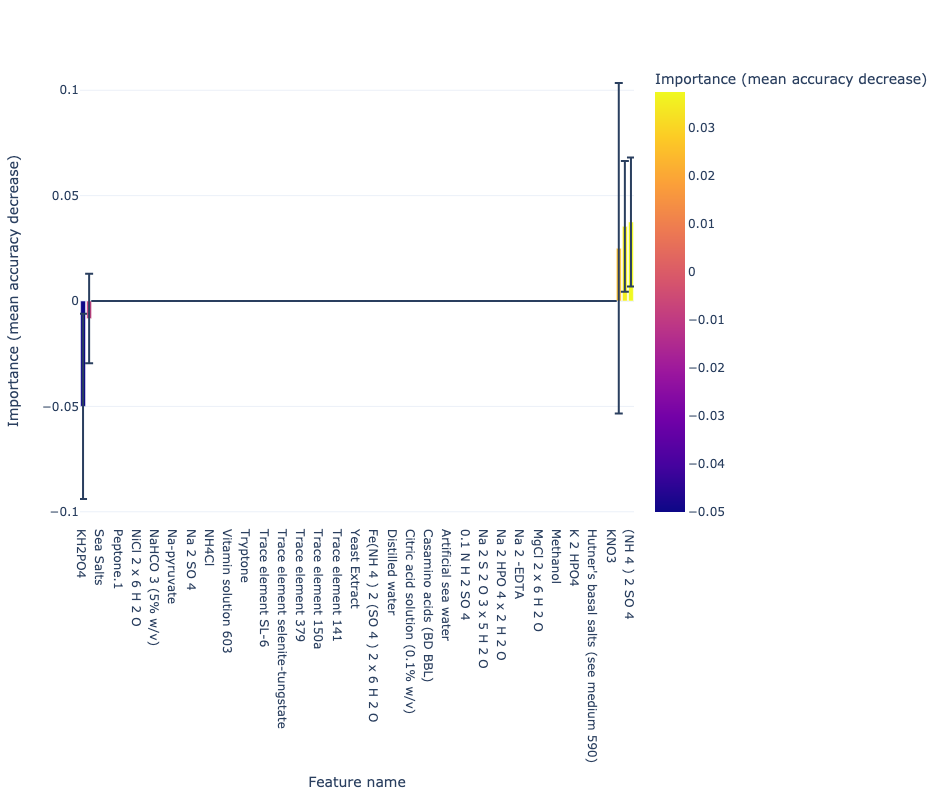

In [13]:
from sklearn.inspection import permutation_importance

result_importances = permutation_importance(
    model,
    X_test,
    y_test,
    n_repeats=30,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

feat_importances = pd.DataFrame({
    "Feature name": X_train.columns,
    "Importance (mean accuracy decrease)": result_importances.importances_mean,
    "Importance (std)": result_importances.importances_std
})

# Sort them by mean
feat_importances = feat_importances\
    .sort_values("Importance (mean accuracy decrease)")

fig = px.bar(
    data_frame=feat_importances,
    x="Feature name",
    y="Importance (mean accuracy decrease)",
    error_y="Importance (std)",
    color="Importance (mean accuracy decrease)",
    width=950,
    height=800,
    template="plotly_white"
)
fig.show("png")

#### Metrics

In [14]:
y_pred = model.predict(X_test)

report = classification_report(
    y_true=y_test,
    y_pred=y_pred,
    zero_division="warn"
)

print(report)

              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       1.00      0.86      0.92         7
           2       0.57      0.80      0.67         5

    accuracy                           0.75        16
   macro avg       0.75      0.72      0.72        16
weighted avg       0.78      0.75      0.76        16



In [15]:
from sklearn import metrics

# TODO: get PR-REC AUC score
# TODO: plot both ROC and PR-REC curves
roc_score = metrics.roc_auc_score(
    y_true=y_test,
    y_score=model.predict_proba(X_test),
    average="weighted",
    multi_class="ovo"
)

print("ROC AUC score:", roc_score)

ROC AUC score: 0.9243861607142858
